In [1]:
import os
import sys
import glob
from os.path import abspath
os.environ['SPARK_HOME'] = 'C:\spark-3.1.2-bin-hadoop3.2'
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jdk1.8.0_201'
os.environ['HADOOP_HOME'] = 'C:\spark-3.1.2-bin-hadoop3.2'
spark_python = os.path.join(os.environ.get('SPARK_HOME',None),'python')
py4j = glob.glob(os.path.join(spark_python,'lib','py4j-*.zip'))[0]
graphf = glob.glob(os.path.join(spark_python,'graphframes.zip'))[0]
sys.path[:0]=[spark_python,py4j]
sys.path[:0]=[spark_python,graphf]
os.environ['PYTHONPATH']=py4j+os.pathsep+graphf
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Spark Examples").enableHiveSupport().getOrCreate()

In [2]:
from graphframes import *
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
transport_nodes = spark.read.format("csv").option("inferSchema", "true").option("header", "true").load("transport-nodes.csv")
transport_nodes.show()

+----------------+---------+---------+----------+
|              id| latitude|longitude|population|
+----------------+---------+---------+----------+
|       Amsterdam|52.379189| 4.899431|    821752|
|         Utrecht|52.092876|  5.10448|    334176|
|        Den Haag|52.078663| 4.288788|    514861|
|       Immingham| 53.61239| -0.22219|      9642|
|       Doncaster| 53.52285| -1.13116|    302400|
|Hoek van Holland|  51.9775|  4.13333|      9382|
|      Felixstowe| 51.96375|   1.3511|     23689|
|         Ipswich| 52.05917|  1.15545|    133384|
|      Colchester| 51.88921|  0.90421|    104390|
|          London|51.509865|-0.118092|   8787892|
|       Rotterdam|  51.9225|  4.47917|    623652|
|           Gouda| 52.01667|  4.70833|     70939|
+----------------+---------+---------+----------+



In [5]:
transport_relationships = spark.read.format("csv").option("inferSchema", "true").option("header", "true").load("transport-relationships.csv")
transport_relationships.show()

+----------------+----------------+------------+----+
|             src|             dst|relationship|cost|
+----------------+----------------+------------+----+
|       Amsterdam|         Utrecht|         BUS|  46|
|       Amsterdam|        Den Haag|         BUS|  59|
|        Den Haag|       Rotterdam|         BUS|  26|
|       Amsterdam|       Immingham|        TAXI| 369|
|       Immingham|       Doncaster|         BUS|  74|
|       Doncaster|          London|        TAXI| 277|
|Hoek van Holland|        Den Haag|         BUS|  27|
|      Felixstowe|Hoek van Holland|        TAXI| 207|
|         Ipswich|      Felixstowe|         BUS|  22|
|      Colchester|         Ipswich|         BUS|  32|
|          London|      Colchester|        TAXI| 106|
|           Gouda|       Rotterdam|         BUS|  25|
|           Gouda|         Utrecht|         BUS|  35|
|        Den Haag|           Gouda|         BUS|  32|
|Hoek van Holland|       Rotterdam|         BUS|  33|
+----------------+----------

In [11]:
 # the function will plot the source and destination nodes and connect them by meand of undirected line
def plot_directed_graph(edge_list):
    plt.figure(figsize=(9,9))
    gplot=nx.DiGraph()
    edge_labels = {}
    for row in edge_list.select("src", "dst", "cost").take(1000):
        gplot.add_edge(row["src"], row["dst"])
        edge_labels[(row["src"], row["dst"])] = row["cost"]
    pos = nx.spring_layout(gplot)
    nx.draw(gplot, pos, with_labels=True, font_weight="bold", node_size=3500)
    nx.draw_networkx_edge_labels(gplot, pos, edge_labels=edge_labels, font_color="green", font_size=11, font_weight="bold")

In [12]:
route = GraphFrame(transport_nodes, transport_relationships)

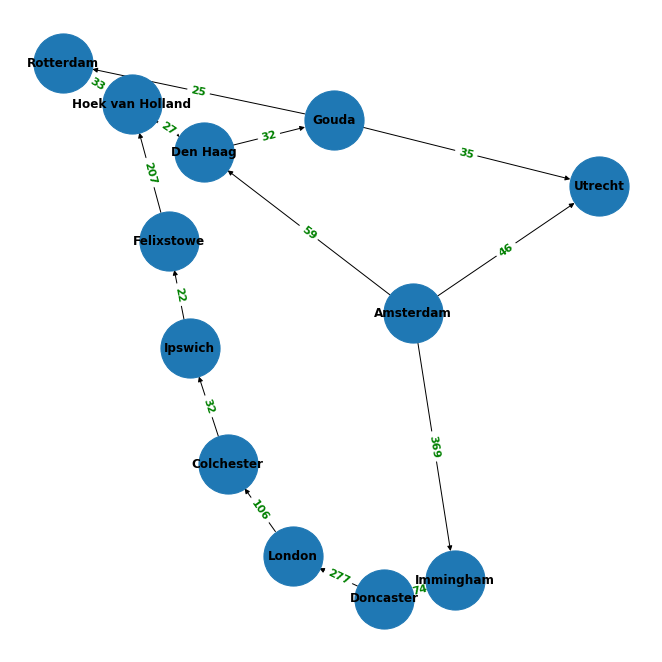

In [15]:
plot_directed_graph(route.edges)

In [16]:
#BFS

filtered_paths = route.bfs("id = 'Gouda'", "id = 'Utrecht'")
filtered_paths.show(truncate=False)
filtered_paths.count()

+---------------------------------+-------------------------+-------------------------------------+
|from                             |e0                       |to                                   |
+---------------------------------+-------------------------+-------------------------------------+
|{Gouda, 52.01667, 4.70833, 70939}|{Gouda, Utrecht, BUS, 35}|{Utrecht, 52.092876, 5.10448, 334176}|
+---------------------------------+-------------------------+-------------------------------------+



1

In [17]:
#BFS

filtered_paths = route.bfs("id = 'Gouda'", "id = 'Felixstowe'")
filtered_paths.show(truncate=False)
filtered_paths.count()

+---+--------+---------+----------+
|id |latitude|longitude|population|
+---+--------+---------+----------+
+---+--------+---------+----------+



0

In [18]:
#BFS

filtered_paths = route.bfs("id = 'Amsterdam'", "id = 'Felixstowe'")
filtered_paths.show(truncate=False)
filtered_paths.count()

+----------------------------------------+---------------------------------+-------------------------------------+-------------------------------+---------------------------------------+------------------------------+---------------------------------------+-------------------------------+---------------------------------------+------------------------------+------------------------------------+------------------------------+-------------------------------------+
|from                                    |e0                               |v1                                   |e1                             |v2                                     |e2                            |v3                                     |e3                             |v4                                     |e4                            |v5                                  |e5                            |to                                   |
+----------------------------------------+------------------------

1

In [19]:
#BFS

filtered_paths = route.bfs("id = 'Amsterdam'", "population < 500000")
filtered_paths.show(truncate=False)
filtered_paths.count()


+----------------------------------------+---------------------------------+-------------------------------------+
|from                                    |e0                               |to                                   |
+----------------------------------------+---------------------------------+-------------------------------------+
|{Amsterdam, 52.379189, 4.899431, 821752}|{Amsterdam, Immingham, TAXI, 369}|{Immingham, 53.61239, -0.22219, 9642}|
|{Amsterdam, 52.379189, 4.899431, 821752}|{Amsterdam, Utrecht, BUS, 46}    |{Utrecht, 52.092876, 5.10448, 334176}|
+----------------------------------------+---------------------------------+-------------------------------------+



2

In [20]:
#BFS

filtered_paths = route.bfs("id = 'Amsterdam'", "id = 'London'", maxPathLength=5)
filtered_paths.show(truncate=False)
filtered_paths.count()

+----------------------------------------+---------------------------------+-------------------------------------+-------------------------------+---------------------------------------+------------------------------+---------------------------------------+
|from                                    |e0                               |v1                                   |e1                             |v2                                     |e2                            |to                                     |
+----------------------------------------+---------------------------------+-------------------------------------+-------------------------------+---------------------------------------+------------------------------+---------------------------------------+
|{Amsterdam, 52.379189, 4.899431, 821752}|{Amsterdam, Immingham, TAXI, 369}|{Immingham, 53.61239, -0.22219, 9642}|{Immingham, Doncaster, BUS, 74}|{Doncaster, 53.52285, -1.13116, 302400}|{Doncaster, London, TAXI, 277}|{London, 

1

In [22]:
# shortest path 

filtered_paths = route.shortestPaths(landmarks=["Ipswich"])

filtered_paths.show(truncate=False)
filtered_paths.count()

+----------------+---------+---------+----------+--------------+
|id              |latitude |longitude|population|distances     |
+----------------+---------+---------+----------+--------------+
|London          |51.509865|-0.118092|8787892   |{Ipswich -> 2}|
|Felixstowe      |51.96375 |1.3511   |23689     |{}            |
|Rotterdam       |51.9225  |4.47917  |623652    |{}            |
|Ipswich         |52.05917 |1.15545  |133384    |{Ipswich -> 0}|
|Hoek van Holland|51.9775  |4.13333  |9382      |{}            |
|Gouda           |52.01667 |4.70833  |70939     |{}            |
|Immingham       |53.61239 |-0.22219 |9642      |{Ipswich -> 4}|
|Amsterdam       |52.379189|4.899431 |821752    |{Ipswich -> 5}|
|Colchester      |51.88921 |0.90421  |104390    |{Ipswich -> 1}|
|Utrecht         |52.092876|5.10448  |334176    |{}            |
|Den Haag        |52.078663|4.288788 |514861    |{}            |
|Doncaster       |53.52285 |-1.13116 |302400    |{Ipswich -> 3}|
+----------------+-------

12